# Attention

**Goal:** Figure out if the `TransformerEncoderLayer` was even necessary, or if I could have gotten just as far (or close to as far) with a layers or two of attention.
(It's nice to have fewer hyperparameters to tune I think?)

In [19]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from glob import glob
import uproot
import json
import matplotlib.pyplot as plt

import math

import networkx as nx
import torch
from torch import nn
import torch.nn.functional as F
from itertools import combinations

from preprocess import getNumPairs, scale, transformData, prepareData,jetVars
from trainNet import getGNNDataLoaders, pairAGraph, check_accuracy, train

from preprocess import getHCs, applyCuts, getHelicityAngles
from uproot_methods.classes.TLorentzVector import TLorentzVectorArray

import os
os.sys.path.append('../code')
from analysis import normalizeWeight
from eventDisplays import truthDisplay

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
physicsSample = 'SMNR'
nSelectedJets = 5
prodTag = 'MAR2020'

In [11]:
class basicAttn(nn.Module):
    
    def __init__(self, inpt_dim=5, embed_dim=20, nHeads=4, njets=4):
        '''
        Just use a (couple) layers of an attention mechansim, b/c I'm not sure if all the bells
        and whistles of the transformer models was necessary - or if this was just *complicating*
        matters.
        
        Inputs:    
        - in_dim: # of features used to repn each jet
        - embed_dim: size of the latent space representing the jets
        - nAttnBlocks: # of attn blocks to use before classifying 
                       the edges
        - nHeads:
        - p: dropout fraction
        - njets: Max # of jets to include

        '''
        super(basicAttn, self).__init__()
    
        self.toLatent = nn.Linear(inpt_dim,embed_dim,bias=True)

        self.attnLayer = nn.MultiheadAttention(embed_dim, num_heads=nHeads)
        
        self.embed_dim = embed_dim
        self.njets = njets
    
        self.score = lambda h: \
            torch.cat([(torch.bmm(h[h11].view(-1,1,embed_dim), h[h12].view(-1,embed_dim,1)) \
                       + torch.bmm(h[h21].view(-1,1,embed_dim), h[h22].view(-1,embed_dim,1))).squeeze(-1)
                       for i0,i1,i2,i3 in combinations(range(self.njets),4) \
                       for (h11,h12), (h21, h22) in zip([(i0,i1),(i0,i2),(i0,i3)],[(i2,i3),(i1,i3),(i1,i2)]) ],
                      axis=1)

    def forward(self, x):
        '''
        Inputs:
        - x has shape (batchSize, nJets, nFeatures)
        '''
        self.njets = x.shape[1]
        
        xi = x.permute(1,0,2) 
        h = self.toLatent(xi)
        
        h = nn.ReLU()(h)

        h, e = self.attnLayer(h,h,h)       
        score = self.score(h)
        
        return score, e


**Get the data loaders**

In [118]:
batch_size=2048
loader_train, loader_val = getGNNDataLoaders(batch_size,nSelectedJets=nSelectedJets,prodTag=prodTag)

350932  train + val events


**Make a basic model**

In [80]:
m = basicAttn(inpt_dim=len(jetVars))

In [14]:
for p in m.parameters():
    print(p.shape)

torch.Size([20, 5])
torch.Size([20])
torch.Size([60, 20])
torch.Size([60])
torch.Size([20, 20])
torch.Size([20])


In [20]:
100+20+1200+60+400+20

1800

In [18]:
np.sum([np.prod(p.shape) for p in m.parameters()])

1800

**Define the model and figure directories before training**

In [20]:
subDir = f"{physicsSample}_mc16ade_PFlow-{prodTag}-{nSelectedJets}jets"

# Read in the parameters of the model 
embed_dim = 20
nHeads, nLayers = 4, 1
scoreFct = 'jetCompatibility'
lr = .01

# If the directory doesn't exist - create it!
specs = f"attn_latent_1block_dim{embed_dim}_{nHeads}heads_{scoreFct}_lr{lr}_batch{batch_size}_mask"
modelDir = f"models/{subDir}/{specs}/"
figDir = f"figures/{subDir}/{specs}/"
if not os.path.exists(modelDir): os.mkdir(modelDir)
if not os.path.exists(figDir): os.mkdir(figDir)


Epoch  0 | Train loss  2.682 | Val loss  1.522 | Train acc 0.815 | Val acc 0.815
Epoch  1 | Train loss  1.271 | Val loss  1.178 | Train acc 0.854 | Val acc 0.854
Epoch  2 | Train loss  1.083 | Val loss  1.030 | Train acc 0.869 | Val acc 0.869
Epoch  3 | Train loss  1.012 | Val loss  0.959 | Train acc 0.877 | Val acc 0.877
Epoch  4 | Train loss  0.976 | Val loss  0.929 | Train acc 0.879 | Val acc 0.882
Epoch  5 | Train loss  0.956 | Val loss  0.913 | Train acc 0.881 | Val acc 0.882
Epoch  6 | Train loss  0.944 | Val loss  0.916 | Train acc 0.882 | Val acc 0.883
Epoch  7 | Train loss  0.945 | Val loss  0.889 | Train acc 0.881 | Val acc 0.884
Epoch  8 | Train loss  0.939 | Val loss  0.911 | Train acc 0.881 | Val acc 0.882
Epoch  9 | Train loss  0.940 | Val loss  0.893 | Train acc 0.880 | Val acc 0.881
Epoch 10 | Train loss  0.961 | Val loss  0.875 | Train acc 0.882 | Val acc 0.884
Epoch 11 | Train loss  1.046 | Val loss  0.940 | Train acc 0.876 | Val acc 0.881
Epoch 12 | Train loss  0.928

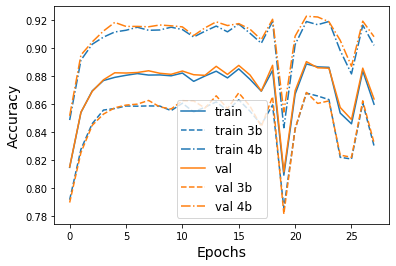

In [23]:
train(m,loader_train, loader_val, lr, 50, 5,'cuda:1', modelDir, figDir, masked=True)

**First sanity check**

Let's see how the performance changes when we rotate the entire event!

**Needed**
1. Events with all of the truth info loaded so that I can make the "pretty plot"
2. A way to *quicklyt* apply the ml scaling to be able to evaluate the output
3. A decision if I want to plot the `scores` or what they'll look like after passing them through a softmax layer


I ended up moving those studies into another nb - `Azimuthal-Symmetry`. So for now, let's maybe load in the trained model, and check out where the *loss* in accuracy is coming from c.f. my baseline hyperparameters?

In [81]:
m.load_state_dict(torch.load(f'{modelDir}/model.pt',map_location='cpu'))
m.eval()

basicAttn(
  (toLatent): Linear(in_features=5, out_features=20, bias=True)
  (attnLayer): MultiheadAttention(
    (out_proj): Linear(in_features=20, out_features=20, bias=True)
  )
)

Scaling pt.
Scaling E.


/opt/rh/rh-python36/root/usr/lib64/python3.6/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block5_values] [items->Index(['HLT_2j35_bmv2c2060_split_2j35_L14J15.0ETA25',
       'HLT_j100_2j55_bmv2c2060_split', 'HLT_j225_bmv2c2060_split',
       'HLT_2j15_gsc35_bmv2c1040_split_2j15_gsc35_boffperf_split_L14J15.0ETA25',
       'HLT_2j35_gsc55_bmv2c1050_split_ht300_L1HT190-J15s5.ETA21',
       'HLT_j110_gsc150_boffperf_split_2j35_gsc55_bmv2c1070_split_L1J85_3J30',
       'HLT_j225_gsc300_bmv2c1070_split',
       'HLT_j35_gsc55_bmv2c1050_split_ht700_L1HT190-J15s5.ETA21',
       'HLT_2j45_gsc55_bmv2c1050_split_ht300_L1HT190-J15s5.ETA21',
       'HLT_2j35_bmv2c1060_split_2j35_L14J15.0ETA25',
       'HLT_j110_gsc150_boffperf_split_2j45_gsc55_bmv2c1070_split_L1J85_3J30'],
      dtype='object')]

  encoding=encoding,


Scaling pt.
Scaling E.
Saving  ../data/SMNR_mc16a_PFlow-MAR2020-5jets/df_3b_scaledInputs.h5
Scaling pt.
Scaling E.
Saving  ../data/SMNR_mc16d_PFlow-MAR2020-5jets/df_3b_scaledInputs.h5
Scaling pt.
Scaling E.
Saving  ../data/SMNR_mc16e_PFlow-MAR2020-5jets/df_3b_scaledInputs.h5


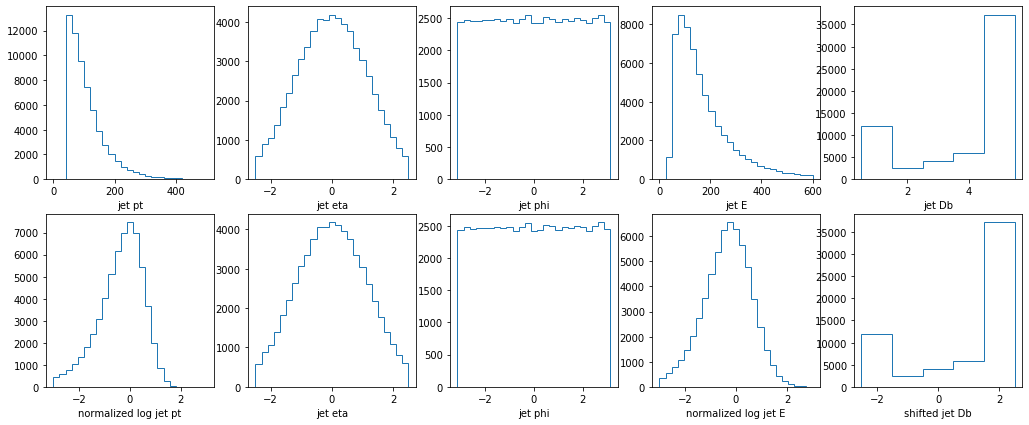

In [119]:
prepareData(nSelectedJets,prodTag=prodTag)

**Check the 4b accuracy on the test set**

In [11]:
mc = 'mc16a'

Ls = {
        15: 3.2,
        'a': 24.5556, # for now - just use the 2016 luminosity to normalize mc16a
        'd': 43.65,
        'e': 58.45
    }

In [120]:
subDir = f"{physicsSample}_{mc}_PFlow-{prodTag}-{nSelectedJets}jets"
df = pd.read_hdf(f"../data/{subDir}/df_3b_scaledInputs.h5", key='df')
print('even',np.sum(df.loc[df.index % 2 == 0,'mcEventWeight']),'odd',np.sum(df.loc[df.index % 2 == 1,'mcEventWeight']))

df = df[df.index % 2 == 1]

# Since I'm only using half the stats for the test set, need to multiply L by 2.
L = Ls[mc[-1]]
key = f'{physicsSample}_{mc}_PFlow-{prodTag}'
print(key)
normalizeWeight(df,key,lumi=L*2)

even 3568.9678 odd 3580.6074
SMNR_mc16a_PFlow-MAR2020
/u/ki/nhartman/gpfs/public/hh4b/SMNR/user.jagrundy.HH4B.450000.SM_HH.MC16a-2015-2016.AB21.2.91-MAR20-0.full_MiniNTuple.root/user.jagrundy.20736236._000001.MiniNTuple.root
sum_weights_initial 26458.62742272562
xsec 27.47
k_factor 1.13
gen_filter_eff 0.3392
sample_weight 0.019543672735207792


In [109]:
applyCuts(df,m,nSelectedJets)

max(njets) 5
Getting jet pts
Getting jet etas
Getting jet phis
Getting jet Es
Calculating Xwt
Calculating Xhh


In [110]:
for nj in [4,5]:
    print(f'{nj} jets')
    for nb,mi in zip([4,3],[(df.ntag>=4),(df.ntag==3)]):
        mask = (df.njets == nj) & mi & (df.goodJets)
        acc = np.sum(df.loc[(df.predPair == df.correctPair) & mask,'mc_sf']) /np.sum(df.loc[mask,'mc_sf'])
        print(f'  {nb}b acc: {acc*100:.2f} %')

4 jets
  4b acc: 93.65 %
  3b acc: 91.72 %
5 jets
  4b acc: 89.40 %
  3b acc: 80.60 %


In [111]:
mask = (df.ntag>=4) & (df.correctPair!=-1)
acc = np.sum(df.loc[(df.predPair == df.correctPair) & mask,'mc_sf']) /np.sum(df.loc[mask,'mc_sf'])
acc

0.9171343037368793

In [112]:
check_accuracy(loader_train,m,btag=4,masked=True)

0.9152330756187439

In [113]:
check_accuracy(loader_val,m,btag=4,masked=True)

0.916769802570343

In [121]:
np.sum(df.goodJets)

89059

In [122]:
np.sum(df.correctPair!=-1)

89059

In [90]:
for c in df.columns:
    print(c)

eventNumber
nresolvedJets
resolved_nBTags
mcEventWeight
weight_pileup
rand_run_nr
j0_pt
j0_eta
j0_phi
j0_E
j0_Db
j0_sf
j1_pt
j1_eta
j1_phi
j1_E
j1_Db
j1_sf
j2_pt
j2_eta
j2_phi
j2_E
j2_Db
j2_sf
j3_pt
j3_eta
j3_phi
j3_E
j3_Db
j3_sf
j4_pt
j4_eta
j4_phi
j4_E
j4_Db
j4_sf
njets
HLT_2j35_bmv2c2060_split_2j35_L14J15.0ETA25
HLT_j100_2j55_bmv2c2060_split
HLT_j225_bmv2c2060_split
trigger
mc_sf
ntag
h0_pt
h0_eta
h0_phi
h0_barcode
h1_pt
h1_eta
h1_phi
h1_barcode
b0_pt
b0_eta
b0_phi
b0_parent_barcode
b1_pt
b1_eta
b1_phi
b1_parent_barcode
b2_pt
b2_eta
b2_phi
b2_parent_barcode
b3_pt
b3_eta
b3_phi
b3_parent_barcode
truth_mhh
truth_pthh
b0_jidx
b0_drMatch
b1_jidx
b1_drMatch
b2_jidx
b2_drMatch
b3_jidx
b3_drMatch
j0_bidx
j1_bidx
j2_bidx
j3_bidx
j4_bidx
j0_drMatch
j1_drMatch
j2_drMatch
j3_drMatch
j4_drMatch
correctPair
sameParent
unique
dRmatch
goodJets
ml_j0_pt
ml_j1_pt
ml_j2_pt
ml_j3_pt
ml_j4_pt
ml_j0_eta
ml_j1_eta
ml_j2_eta
ml_j3_eta
ml_j4_eta
ml_j0_phi
ml_j1_phi
ml_j2_phi
ml_j3_phi
ml_j4_phi
ml_j0_E
ml_

In [116]:
df.loc[df.goodJets & (df.correctPair==-1),[f'j{i}_bidx' for i in range(nSelectedJets)]+[f'b{i}_jidx' for i in range(4)]]

j0_bidx  j1_bidx  j2_bidx  j3_bidx  j4_bidx  b0_jidx  b1_jidx  \
entry                                                                   
637           0       -1        1        2        3        0        2   
1333          0       -1        3        2        1        0        4   
2085         -1        0        1        2        3        1        2   
3021          0       -1        1        2        3        0        2   
4105          0       -1        1        2        3        0        2   
...         ...      ...      ...      ...      ...      ...      ...   
771183        0        2        1       -1        3        0        2   
771475        0        2        1       -1        3        0        2   
771895       -1        0        1        2        3        1        2   
772987        0       -1        1        2        3        0        2   
775065        1        0       -1        3        2        1        0   

        b2_jidx  b3_jidx  
entry                     
637           3        4  
1333          3        2  
2085          3        4  
3021          3        4  
4105          3        4  
...         ...      ...  
771183        1        4  
771475        1        4  
771895        3        4  
772987        3        4  
775065        4        3  

[381 rows x 9 columns]

In [117]:
df.loc[df.goodJets & (df.correctPair==-1),[f'b{i}_{v}' for v in ['jidx','drMatch','parent_barcode'] for i in range(4) ]]

b0_jidx  b1_jidx  b2_jidx  b3_jidx  b0_drMatch  b1_drMatch  \
entry                                                                
637           0        2        3        4    0.010662    0.025897   
1333          0        4        3        2    0.107947    0.147350   
2085          1        2        3        4    0.010017    0.005793   
3021          0        2        3        4    0.093073    0.006084   
4105          0        2        3        4    0.012929    0.007901   
...         ...      ...      ...      ...         ...         ...   
771183        0        2        1        4    0.003827    0.028345   
771475        0        2        1        4    0.044996    0.007646   
771895        1        2        3        4    0.023067    0.073621   
772987        0        2        3        4    0.011462    0.067515   
775065        1        0        4        3    0.020503    0.128688   

        b2_drMatch  b3_drMatch  b0_parent_barcode  b1_parent_barcode  \
entry                                                                  
637       0.009392    0.203337              10096              10095   
1333      0.009952    0.015796              10074              10074   
2085      0.016334    0.081872              10074              10073   
3021      0.132879    0.222963              10111              10112   
4105      0.059577    0.210615              10100              10099   
...            ...         ...                ...                ...   
771183    0.069480    0.280806              10097              10098   
771475    0.002097    0.247257              10113              10114   
771895    0.062062    0.247941              10064              10063   
772987    0.047001    0.162087              10075              10076   
775065    0.147050    0.033925              10129              10130   

        b2_parent_barcode  b3_parent_barcode  
entry                                         
637                 10096              10095  
1333                10073              10073  
2085                10074              10073  
3021                10112              10111  
4105                10099              10100  
...                   ...                ...  
771183              10098              10097  
771475              10114              10113  
771895              10063              10064  
772987              10075              10076  
775065              10130              10129  

[381 rows x 12 columns]

How *big* of an effect is this?

In [101]:
np.sum(df.loc[df.goodJets & (df.correctPair==-1),'mc_sf'])

0.2148490400779665

**Question:** How does this event *not* have a correct pair?? 

In [107]:
df.loc[df.goodJets & (df.correctPair==-1),['njets','nresolvedJets']]

njets  nresolvedJets
entry                       
637         4              9
1333        4              5
2085        4              7
3021        4              9
4105        4              6
...       ...            ...
771183      4              5
771475      4              6
771895      4              5
772987      4              5
775065      4              5

[381 rows x 2 columns]

Ok - so this is *always* happening for four jet events. 

But, this doesn't make sense, b/c the jets seem to be matched to the $5^{th}$ jet in the event.



In [104]:
df.loc[df.goodJets & (df.correctPair==-1),[f'j{i}_{v}' for v in ['pt','eta'] for i in range(nSelectedJets) ]]

j0_pt       j1_pt       j2_pt       j3_pt  j4_pt    j0_eta  \
entry                                                                     
637     410.153107  217.130585  182.349533   84.863968    0.0  1.026807   
1333    575.908508  397.436737  184.810913  150.298584    0.0 -0.301671   
2085    366.403503  243.130127  253.621689  114.915382    0.0 -1.291177   
3021    516.787842  293.847931  233.854950  140.029633    0.0  0.092161   
4105    274.662292  177.293411  135.473572   52.922623    0.0  0.422952   
...            ...         ...         ...         ...    ...       ...   
771183  274.010956  188.210129  152.357559   92.364052    0.0  0.507542   
771475  472.639862  269.152252  249.295929  231.294769    0.0  0.084641   
771895  288.453186  227.668701  130.873505   56.423580    0.0  1.779355   
772987  206.453094  164.807022  114.872261   53.802109    0.0 -0.295221   
775065  631.955566  434.681000  108.046669   76.465508    0.0  0.164115   

          j1_eta    j2_eta    j3_eta  j4_eta  
entry                                         
637     1.856499  1.359358  1.299126     0.0  
1333   -1.365366 -1.062745 -0.335208     0.0  
2085   -1.441098  0.061799 -1.118242     0.0  
3021   -0.049672 -1.778674 -1.916099     0.0  
4105   -2.211285 -0.180672  0.661189     0.0  
...          ...       ...       ...     ...  
771183  0.238173 -0.079416  1.810694     0.0  
771475 -0.140580 -0.333796 -0.868615     0.0  
771895 -0.277335  0.014372 -0.312913     0.0  
772987  1.385112  1.096216 -1.481181     0.0  
775065  0.678190  0.036792  0.606986     0.0  

[381 rows x 10 columns]

Ok - somehow the jets are still called "goodJets" when they're getting matched to a blank jet. 

**This makes no sense.**


**What are the steps going into the correctPair definition, and how do I fix this?**


This *has* to be happening in the `masked` line.

In [ ]:
for i0,i1,i2,i3 in combinations(range(4),4):
    

In [ ]:
matched = np.all(df[[f'j{ii}_bidx' for ii in [i0,i1,i2,i3]]].values>=0,axis=1)

**Compare with accuracy of pairAGraph trained with last times hyperparameters**

Maybe I need multiple layers?

In [ ]:
# class twoLayerAttn(nn.Module):
    
#     def __init__(self, inpt_dim=5, embed_dim=20, ff_dim=20, nHeads=4, njets=4):
#         '''
#         Just use a (couple) layers of an attention mechansim, b/c I'm not sure if all the bells
#         and whistles of the transformer models was necessary - or if this was just *complicating*
#         matters.
        
#         Inputs:    
#         - in_dim: # of features used to repn each jet
#         - embed_dim: size of the latent space representing the jets
#         - nAttnBlocks: # of attn blocks to use before classifying 
#                        the edges
#         - nHeads:
#         - p: dropout fraction
#         - njets: Max # of jets to include

#         '''
#         super(basicAttn, self).__init__()
    
#         self.toLatent = nn.Linear(inpt_dim,embed_dim,bias=True)

#         self.attnLayer = nn.MultiheadAttention(embed_dim, num_heads=nHeads)
        
#         self.embed_dim = embed_dim
#         self.njets = njets
    
#         self.score = lambda h: \
#             torch.cat([(torch.bmm(h[h11].view(-1,1,embed_dim), h[h12].view(-1,embed_dim,1)) \
#                        + torch.bmm(h[h21].view(-1,1,embed_dim), h[h22].view(-1,embed_dim,1))).squeeze(-1)
#                        for i0,i1,i2,i3 in combinations(range(self.njets),4) \
#                        for (h11,h12), (h21, h22) in zip([(i0,i1),(i0,i2),(i0,i3)],[(i2,i3),(i1,i3),(i1,i2)]) ],
#                       axis=1)

#     def forward(self, x):
#         '''
#         Inputs:
#         - x has shape (batchSize, nJets, nFeatures)
#         '''
#         self.njets = x.shape[1]
        
#         xi = x.permute(1,0,2) 
#         h = self.toLatent(xi)
        
#         h = nn.ReLU()(h)

#         h, e = self.attnLayer(h,h,h)       
#         score = self.score(h)
        
#         return score, e
